In [1]:
# Imports and scripts
import pandas as pd
#import modin.pandas as pd
#import ray
#ray.shutdown()
#ray.init()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pathmagic
%matplotlib inline
with pathmagic.context():
    import Preprocess as Prep
    import RelativePaths as RP
    import Evaluation as Eva
    import GatherData as Gather
    import Graphs
    import Utils

system = 'prom'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Laoa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# File containing settings
path_to_yaml = '../config.yaml'
config = Utils.read_yaml_file(path_to_yaml)

files = config['file locations'][system]
preprocess_settings = config['preprocess settings list']

In [3]:
# set file_locations which will be relative to computer in use
from pathlib import Path
raw_data_csv = str(Path.cwd().parent / files['raw data'])
system_folder = str(Path.cwd().parent / files['system folder'])
tmp_csv = str(Path.cwd().parent / files['tmp data'])
table_file = str(Path.cwd().parent / files['preprocess comparisons'])

In [4]:
Gather.gather_architectural_concerns_data(system_folder, raw_data_csv)

Text(0.5, 1.0, 'File distribution of the software architectural concerns for prom')

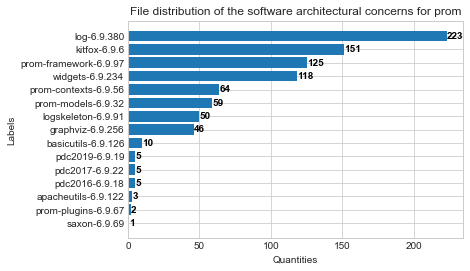

In [5]:
dataset_df = pd.read_csv(raw_data_csv)
y_labels = dataset_df.Label.unique()
x_quantity = [len(dataset_df.loc[dataset_df['Label']==label]) for label in y_labels]
tmp_df = pd.DataFrame({
    'Labels' : y_labels,
    'Quantity' : x_quantity
})
tmp_df = tmp_df.sort_values(by=['Quantity'])
plt.style.use("seaborn-whitegrid")
plt.barh(y=tmp_df.Labels, width=tmp_df.Quantity)
for i, v in enumerate(tmp_df.Quantity):
    plt.text(v, i, str(v), color='black', fontweight='bold', ha='left', va='center')

plt.xlabel('Quantities')
plt.ylabel('Labels')
plt.title('File distribution of the software architectural concerns for ' + system)

# Bag-of-words
    -test-size: 90%
    -100 iterations
    -feature representation: Bag-of-words

In [6]:
df_columns = [
    'classifier',
    'setting_id',
    'settings', 
    'accuracy', 
    'macro_avg_precision', 
    'macro_avg_recall', 
    'train_size', 
    'test_size', 
    'report_table' 
]
main_table = pd.DataFrame(columns=df_columns)
test_size=0.9
fold_quantity = 100

for setting_id, setting in preprocess_settings.items():
    Prep.preprocess_settings(setting, raw_data_csv, tmp_csv)
    tmp_df = pd.read_csv(tmp_csv)

    # Remove GLOBALS and CLI from the dataset
    df_sliced = Utils.remove_concerns_under_quantity_threshold(tmp_df)

    feature_representation = CountVectorizer()
    confusion_list = []

    # Train and gather evaluation metrics
    evaluate = Eva.Evaluation(df_sliced, feature_representation, test_size, fold_quantity, 10)
    classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
    classifier_svm , metrics_svm = evaluate.evaluate_SVM()
    classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()
    
    
    row = Utils.make_dataframe_row(metrics_max_ent, setting, setting_id)
    main_table = main_table.append(row, ignore_index=True)

    row = Utils.make_dataframe_row(metrics_svm, setting, setting_id)
    main_table = main_table.append(row, ignore_index=True)
    
    row = Utils.make_dataframe_row(metrics_naive, setting, setting_id)
    main_table = main_table.append(row, ignore_index=True)
    break

main_table.to_csv(table_file, index=False)

In [7]:
main_table.sort_values(by='accuracy',ascending=[False])

,classifier,setting_id,settings,accuracy,macro_avg_precision,macro_avg_recall,train_size,test_size,report_table
0,MaxEnt,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.825459,0.722886,0.710326,84,762,basicutils-6.9.126 graphviz-6.9.25...
2,Naive-Bayes,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.804462,0.738316,0.746977,84,762,basicutils-6.9.126 graphviz-6.9.25...
1,SVM,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.801837,0.735525,0.693212,84,762,basicutils-6.9.126 graphviz-6.9.25...


In [8]:
main_table.sort_values(by='accuracy',ascending=[False])
comp_table = main_table.sort_values(by='accuracy',ascending=[False])
comp_table['Feature Representation']='Bag of words'

# Tf-idf
    -test-size: 90%
    -10 folds (k-fold)
    -feature representation: Term-frequency inverse document

In [9]:
df_columns = [
    'classifier',
    'setting_id',
    'settings', 
    'accuracy', 
    'macro_avg_precision', 
    'macro_avg_recall', 
    'train_size', 
    'test_size', 
    'report_table' 
]
main_table = pd.DataFrame(columns=df_columns)
test_size=0.9
fold_quantity = 100

for setting_id, setting in preprocess_settings.items():
    Prep.preprocess_settings(setting, raw_data_csv, tmp_csv)
    tmp_df = pd.read_csv(tmp_csv)

    # Remove GLOBALS and CLI from the dataset
    df_sliced = Utils.remove_concerns_under_quantity_threshold(tmp_df)

    feature_representation = TfidfVectorizer(use_idf = True)
    confusion_list = []

    # Train and gather evaluation metrics
    evaluate = Eva.Evaluation(df_sliced, feature_representation, test_size, fold_quantity, 10)
    classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
    classifier_svm , metrics_svm = evaluate.evaluate_SVM()
    classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()
    
    
    row = Utils.make_dataframe_row(metrics_max_ent, setting, setting_id)
    main_table = main_table.append(row, ignore_index=True)

    row = Utils.make_dataframe_row(metrics_svm, setting, setting_id)
    main_table = main_table.append(row, ignore_index=True)
    
    row = Utils.make_dataframe_row(metrics_naive, setting, setting_id)
    main_table = main_table.append(row, ignore_index=True)
    break

main_table.to_csv(table_file, index=False)

In [10]:
main_table.sort_values(by='accuracy',ascending=[False])

,classifier,setting_id,settings,accuracy,macro_avg_precision,macro_avg_recall,train_size,test_size,report_table
1,SVM,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.830709,0.765200,0.725299,84,762,basicutils-6.9.126 graphviz-6.9.25...
2,Naive-Bayes,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.828084,0.832851,0.749930,84,762,basicutils-6.9.126 graphviz-6.9.25...
0,MaxEnt,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.824147,0.823021,0.778691,84,762,basicutils-6.9.126 graphviz-6.9.25...


In [11]:
tmp = main_table.sort_values(by='accuracy',ascending=[False])
tmp['Feature Representation']='Tf-idf'
comp_table=comp_table.append(tmp)
comp_table.sort_values(by='accuracy',ascending=[False])

,classifier,setting_id,settings,accuracy,macro_avg_precision,macro_avg_recall,train_size,test_size,report_table,Feature Representation
1,SVM,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.830709,0.765200,0.725299,84,762,basicutils-6.9.126 graphviz-6.9.25...,Tf-idf
2,Naive-Bayes,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.828084,0.832851,0.749930,84,762,basicutils-6.9.126 graphviz-6.9.25...,Tf-idf
0,MaxEnt,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.825459,0.722886,0.710326,84,762,basicutils-6.9.126 graphviz-6.9.25...,Bag of words
0,MaxEnt,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.824147,0.823021,0.778691,84,762,basicutils-6.9.126 graphviz-6.9.25...,Tf-idf
2,Naive-Bayes,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.804462,0.738316,0.746977,84,762,basicutils-6.9.126 graphviz-6.9.25...,Bag of words
1,SVM,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.801837,0.735525,0.693212,84,762,basicutils-6.9.126 graphviz-6.9.25...,Bag of words
